In [1]:
#python script to detrend, and regrid SST data to what the model is

In [2]:
#load in modules

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
from scipy.signal import detrend

In [2]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38571 instead
  warnings.warn(


In [3]:
#load observational SST
hadsst = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_sst.nc", chunks = {'time':12}).sst
hadsst = hadsst.sortby(hadsst.latitude, ascending=True)
#rename coords
#hadsst = hadsst.rename({"lon": "longitude", "lat": "latitude"})
hadsst =hadsst.sel(time = slice("1900-01-01", "2019-12-31"))
hadsst = hadsst.compute()

In [4]:
hadsst1 = xr.where(hadsst == -1000, np.nan, hadsst)

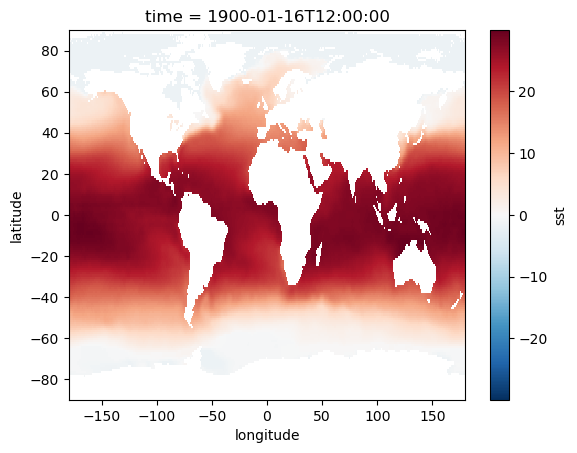

In [6]:
hadsst1[0].plot()

In [7]:
#anoms = (hadsst1.groupby('time.month') - (hadsst1.sel(time=slice('1961-01-01', '1990-12-31')).groupby('time.month').mean('time'))).drop('month')
anoms = (hadsst1.groupby('time.month') - hadsst1.groupby('time.month').mean('time')).drop('month')

In [8]:
import pandas as pd

In [9]:
da = anoms

In [10]:
new_time = pd.date_range('1850-01-16', '1900-01-16', freq='M')

# create a new data array with zeros and the same dimensions as the original array
new_data = np.zeros((len(new_time)))
new_data[:] = np.nan #delete if i want to go back to zeros in middle

# create a new xarray DataArray with the new time index and the zero-filled data
new_array = xr.DataArray(new_data, coords=[new_time], dims=['time'])

# concatenate the new array with the original array along the time dimension
concatenated_array = xr.concat([new_array, da], dim='time')

In [11]:
# create a new time coordinate with monthly frequency for the years 1780-1800
new_times = pd.date_range(start='1680-01', end='1850-1', freq='M')
# create a new DataArray with the time coordinate and fill with NaNs
da_1680_1849 = xr.DataArray(data=np.nan, dims=('time', 'lat', 'lon'), coords={'time': new_times})

# select the slice of data from 1900 to 2020
da_1850_2020 = concatenated_array.sel(time=slice('1850-01-01', '2019-12-31'))

# reverse the order of the data along the time axis
da_1680_1849_data = da_1850_2020.isel(time=slice(None, None, -1))

# update the time coordinate to reflect the new time period
da_1680_1849_data['time'] = new_times

# reindex the data to add the new months from 1780-1800
da_1680_1849_data = da_1680_1849_data.reindex(time=da_1680_1849.time)

# concatenate the three slices along the time axis to get the final DataArray
da_symmetric = xr.concat([da_1680_1849_data, da_1850_2020], dim='time')

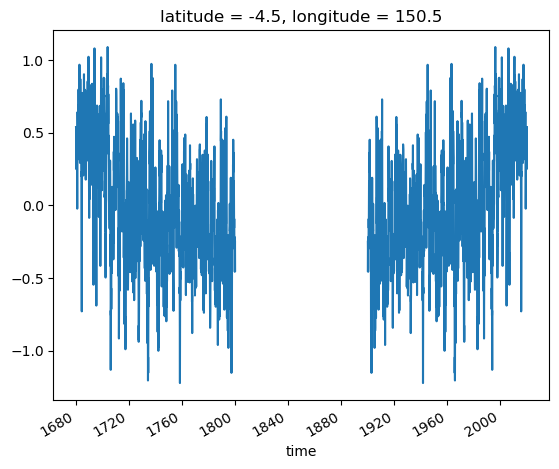

In [12]:
da_symmetric.sel(longitude=150.0, latitude=-5.0, method='nearest').plot()

In [13]:
pv = da_symmetric.polyfit(dim = 'time', deg = 2)###THIS is the solution!

In [14]:
q = xr.polyval(da_symmetric.time, pv)

In [15]:
from datetime import datetime

In [16]:
datetime.strptime("1850-01-01", "%Y-%m-%d") 

datetime.datetime(1850, 1, 1, 0, 0)

In [17]:
q.polyfit_coefficients[-(15*12)]

<xarray.DataArray 'polyfit_coefficients' (latitude: 180, longitude: 360)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [1.31794874e-06, 1.07787780e-06, 1.09558554e-06, ...,
        1.33734838e-06, 1.05854642e-06, 1.35212541e-06],
       [1.01340179e-06, 9.84396542e-07, 1.00191256e-06, ...,
        9.97595877e-07, 9.71596128e-07, 9.76763124e-07],
       [4.78028204e-04, 9.30479386e-07, 4.95214034e-04, ...,
        4.83855939e-04, 4.78036824e-04, 4.71217326e-04]])
Coordinates:
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    time       datetime64[ns] 2005-01-16T12:00:00

In [18]:
#calcualte change in trend from 2020 to 1850
delta_q =  q.polyfit_coefficients[-(15*12)-1] - q.polyfit_coefficients[12*170]

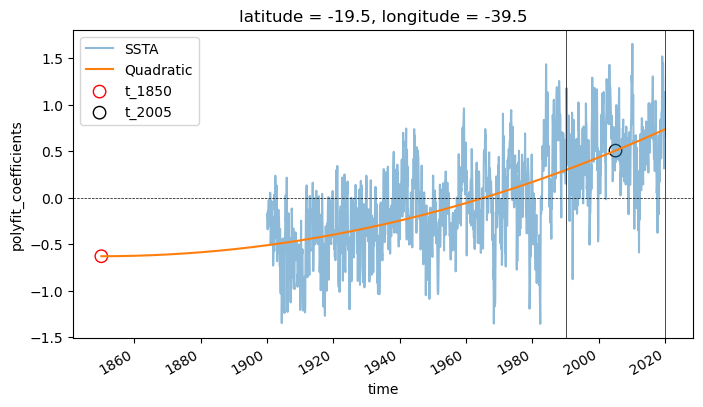

In [19]:
plt.figure(figsize = (8,4))
anoms.sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = 'SSTA', alpha = 0.5)
q.polyfit_coefficients.sel(time=slice("1850-01-01", "2019-12-31")).sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = 'Quadratic')
plt.scatter(q.polyfit_coefficients[12*170].sel(longitude=-40.0, latitude=-20.0, method='nearest').time, 
            q.polyfit_coefficients[12*170].sel(longitude=-40.0, latitude=-20.0, method='nearest').values, s=80, facecolors='none', edgecolors='r', label = 't_1850')
plt.scatter(q.polyfit_coefficients[-15*12].sel(longitude=-40.0, latitude=-20.0, method='nearest').time, 
            q.polyfit_coefficients[-15*12].sel(longitude=-40.0, latitude=-20.0, method='nearest').values, s=80, facecolors='none', edgecolors='k', label = 't_2005')

#q.polyfit_coefficients[12*170].sel(longitude=-40.0, latitude=-20.0, method='nearest').plot.scatter()
#q.polyfit_coefficients[-10*12].sel(longitude=-40.0, latitude=-20.0, method='nearest').plot.scatter()


#(anoms - q.polyfit_coefficients).sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = 'SSTA - trend', alpha = 0.7)

plt.axvline(datetime.strptime("1990-01-01", "%Y-%m-%d"), color = 'k', linestyle = '-', linewidth = 0.5)
plt.axvline(datetime.strptime("2019-12-31", "%Y-%m-%d"), color = 'k', linestyle = '-', linewidth = 0.5)
plt.axhline(0, color = 'k', linestyle = '--', linewidth = 0.5)

plt.legend()


In [20]:
#Modern day climatology is 1990-2019
mod_clim = hadsst1.sel(time=slice("1990-01-01", "2019-12-31")).groupby('time.month').mean('time')

In [21]:
detrended_clim = mod_clim - delta_q

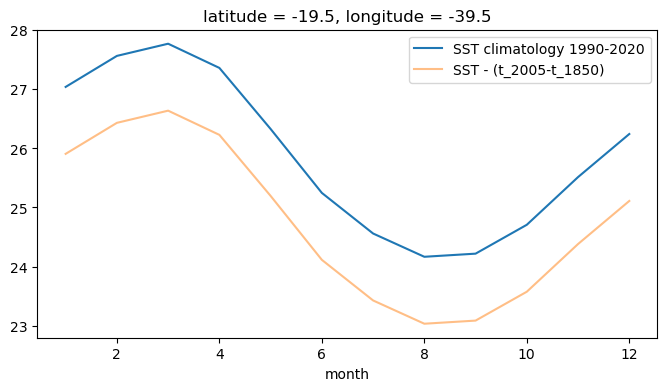

In [22]:
plt.figure(figsize = (8,4))
mod_clim.sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = "SST climatology 1990-2020")
detrended_clim.sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = "SST - (t_2005-t_1850)", alpha = 0.5)

plt.legend()

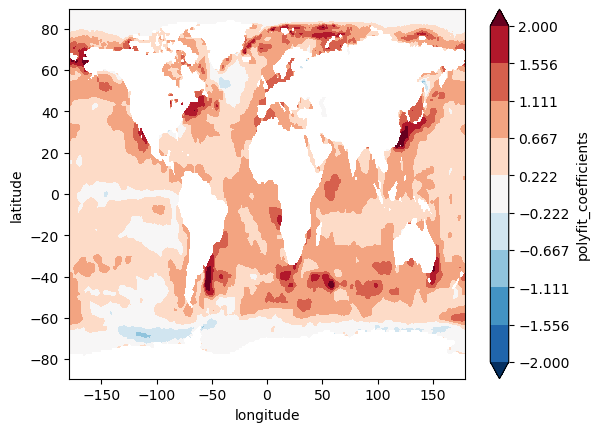

In [23]:
delta_q.plot.contourf(levels = 10, vmin = -2, vmax = 2, cmap = 'RdBu_r', extend = 'both')

In [22]:
#now lets look at the "bias" in the model

In [24]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/ctrl_sst.nc", chunks = {'time':12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [25]:
ctrl_sst

<xarray.Dataset>
Dimensions:   (xt_ocean: 360, yt_ocean: 300, time: 2412)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) object 0950-01-16 12:00:00 ... 1150-12-16 12:00:00
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
Data variables:
    sst       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 300, 360), meta=np.ndarray>

In [26]:
ctrl_sst = ctrl_sst.sel(time = slice('0951-01-16','1100-12-16' ))

In [27]:
def regrid_ACCESS(ds):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds['sst'].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [28]:
%%time
ctrl = regrid_ACCESS(ctrl_sst)

CPU times: user 11.4 s, sys: 1.01 s, total: 12.4 s
Wall time: 17.3 s


In [29]:
ctrl = ctrl.compute()

In [35]:
#now write a fucntion to output bias and to optioanlly plot
def sst_bias(model, obs, freq=None, plot=None, temp_scale = 2):
    """
    Lorem ipsum dolor sit amet, consetetur sadipscing elitr,
    sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam
    
    Parameters
    ----------
    model : argument of type int
        DataArray of model run 
    obs : argument of type int
        Lorem ipsum dolor sit amet
    freq : {‘monthly’, ‘annual’}, optional
        if None default to 'monthly'
    plot : True or False
        if true, plot is made, if false then no
    temp_scale : 2 (optional)
        set to 2 automatically, sets vmin vmax

    """
    #check frequency of sampling, defaukt to monthly if not specified
    if freq == None:
        freq = 'monthly'
    if plot == None:
        plot = False
    #calculate the bias
    if freq == "monthly":
        bias = (model.groupby('time.month').mean('time') - obs.groupby('time.month').mean('time'))
        if plot == True:
            fg = bias.plot.contourf(col='month', col_wrap = 4,  transform=ccrs.PlateCarree(),
                                 subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)}, 
                                  figsize=(20,8), facecolor = 'white', vmin = -1*temp_scale, vmax = temp_scale, levels =10, extend = 'both',  cmap = 'RdBu_r',
                                    cbar_kwargs=dict(label='Bias ($^\\circ$C)'))
            for i, ax in enumerate(fg.axes.flat):
                ax.coastlines()
                #ax.set_facecolor('grey')
                gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
                if i in [0,1,2,3,4,5,6,7]:
                    gl.bottom_labels = False
                if i in [1,2,3,5,6,7,9,10,11]:
                    gl.left_labels = False
                gl.top_labels = False
                gl.right_labels = False               
            #now add the month labels\n",
            titles =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul',
                     'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            for ax,title in zip(fg.axes.flatten(),titles):
                ax.set_title(title )
            return
        elif plot == False:
            return bias
    elif freq == "annual":
        bias = (model.mean('time') - obs.mean('month'))
        if plot == True:
            plt.figure(figsize = (12,8))
            ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
            bias.plot.contourf(ax=ax, vmin = -1*temp_scale, vmax = temp_scale, cmap = "RdBu_r", levels = 10, extend = 'both',
                   transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Bias ($^\\circ$C)'))
            ax.set_title('Annual mean SST bias')
            ax.coastlines(color = 'k')
            ax.gridlines()
            #ax.set_facecolor('grey')
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            return 
        elif plot == False:
            return bias

Text(0.5, 1.0, 'ACCESS-CM2 SST bias (raw HadSST)')

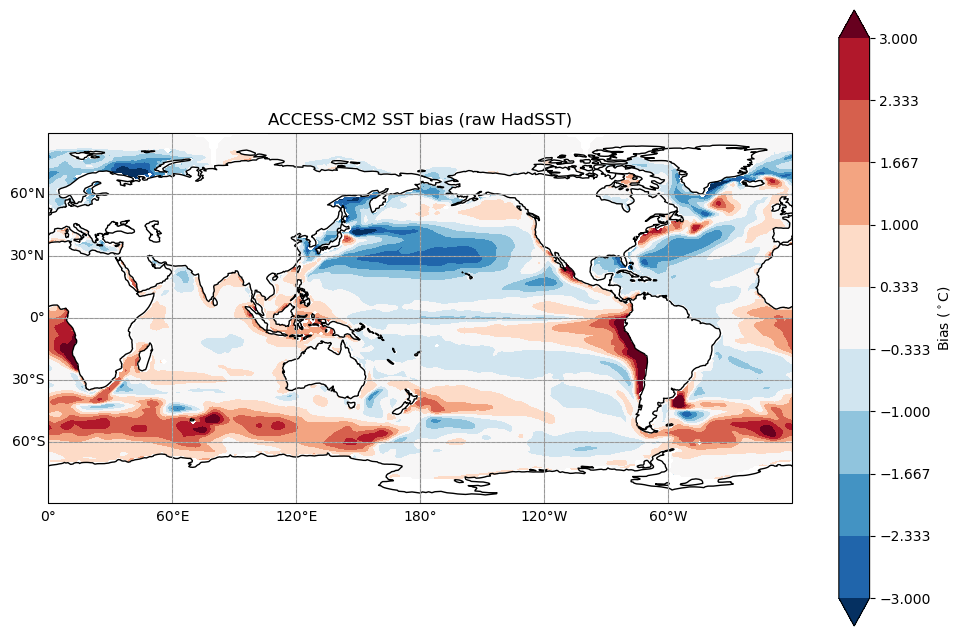

In [31]:
sst_bias(ctrl, hadsst1, "annual", plot=True, temp_scale=3)
plt.title("ACCESS-CM2 SST bias (raw HadSST)")


Text(0.5, 1.0, 'ACCESS-CM2 SST bias (detrended to 1850 HadSST)')

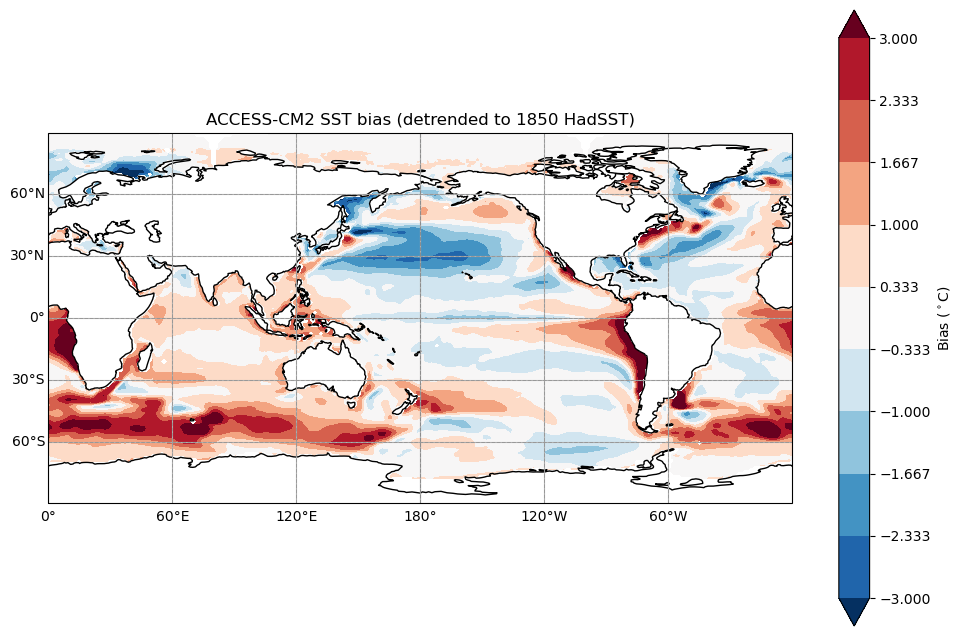

In [36]:
sst_bias(ctrl, detrended_clim, "annual", plot=True, temp_scale=3)
plt.title("ACCESS-CM2 SST bias (detrended to 1850 HadSST)")

Text(0.5, 1.0, 'difference raw HadSST and detrended')

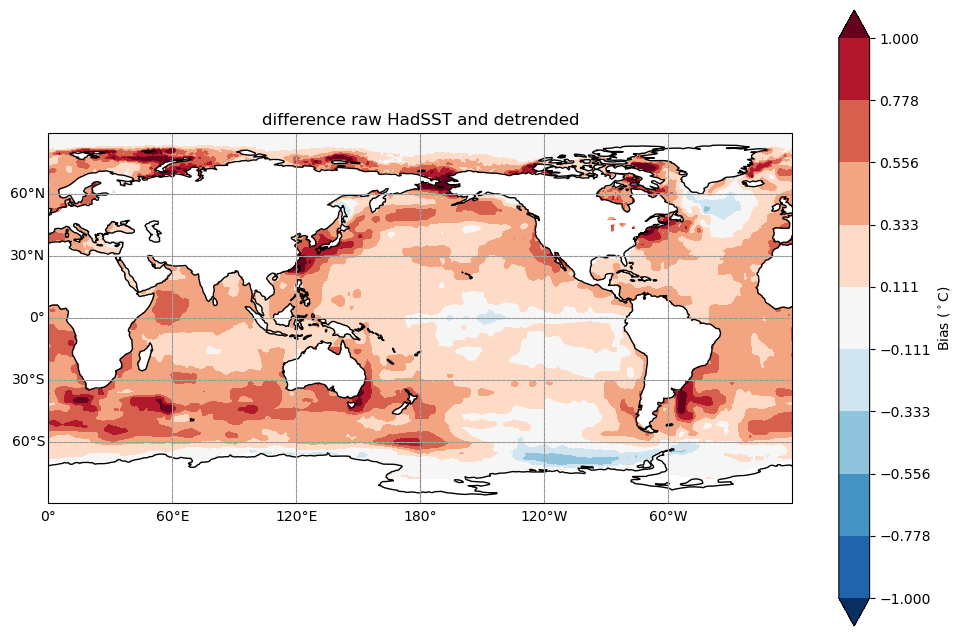

In [37]:
sst_bias(hadsst1, detrended_clim, "annual", plot=True, temp_scale=1)
plt.title("difference raw HadSST and detrended")

Dilate the coastlines by a few grid points. Take the mean of the surrounding points to fill in values

In [177]:
%%time
for i in detrended_clim.latitude:
    for j in detrended_clim.longitude:
        try:            
            #if the point is a nan and at least one surrounding point is ocean then do following
            if np.isnan(detrended_clim[0].sel(longitude = j, latitude = i)) and (
                np.isfinite(detrended_clim[0].sel(longitude = j+1, latitude = i)) or 
                np.isfinite(detrended_clim[0].sel(longitude = j-1, latitude = i)) or
                np.isfinite(detrended_clim[0].sel(longitude = j, latitude = i+1)) or
                np.isfinite(detrended_clim[0].sel(longitude = j, latitude = i-1)) or
                np.isfinite(detrended_clim[0].sel(longitude = j+1, latitude = i+1)) or
                np.isfinite(detrended_clim[0].sel(longitude = j+1, latitude = i-1)) or
                np.isfinite(detrended_clim[0].sel(longitude = j-1, latitude = i-1)) or
                np.isfinite(detrended_clim[0].sel(longitude = j-1, latitude = i+1))):# is True:
                #calculate replacement value
                    rep = detrended_clim3.sel(longitude = slice(j-1, j+1), latitude =slice(i-1, i+1)).mean(['latitude', 'longitude'])
                    #replace value with weighted nearest neighbours
                    detrended_clim2.loc[{'latitude': i, 'longitude': j}] = rep
        except:
            pass

CPU times: user 9min 14s, sys: 11.1 s, total: 9min 26s
Wall time: 9min 26s


In [38]:
# Create a mask of NaN values
nan_mask = np.isnan(detrended_clim[0])

# Create a mask of ocean points (i.e., non-NaN)
ocean_mask = (~nan_mask)
# Create a mask of points that are NaN and surrounded by at least one ocean point
replace_mask = nan_mask & (
    ocean_mask.shift(latitude=1, fill_value=False) | 
    ocean_mask.shift(latitude=-1, fill_value=False) | 
    ocean_mask.shift(longitude=1, fill_value=False) | 
    ocean_mask.shift(longitude=-1, fill_value=False) | 
    ocean_mask.shift(latitude=1, longitude=1, fill_value=False) | 
    ocean_mask.shift(latitude=1, longitude=-1, fill_value=False) | 
    ocean_mask.shift(latitude=-1, longitude=-1, fill_value=False) | 
    ocean_mask.shift(latitude=-1, longitude=1, fill_value=False)
)

In [39]:
#calculate replacement values by generating a 5x5 mean box for each cell
rep = detrended_clim.rolling(latitude=3, longitude=3, center=True, min_periods=1).mean()

In [40]:
detrended_clim_coast = detrended_clim.where(~replace_mask, rep)

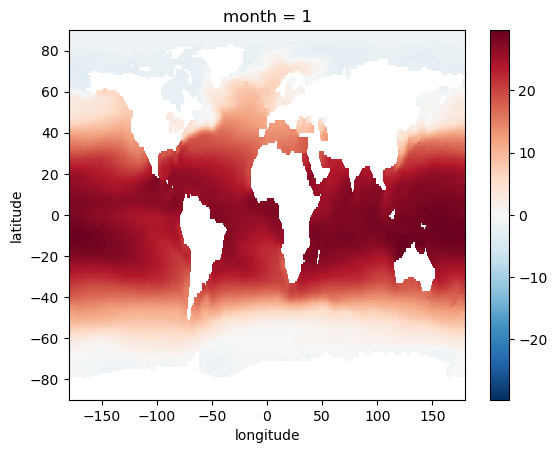

In [41]:
detrended_clim_coast[0].plot()

In [42]:
ctrl = xr.open_dataset("/g/data/hh5/tmp/zg0866/cm000_APP4_archive/cm000/history/ocn/ocean_month.nc-09501231",
                         use_cftime=True)

In [43]:
dht = ctrl.dht[:,0]

In [44]:
lsm = xr.where(dht>0, 1, np.nan)

In [49]:
def roll_lon(df):
    df.coords['xt_ocean'] = (df.coords['xt_ocean'] + 360) % 360# - 180
    df = df.sortby(df.xt_ocean)
    return df

In [50]:
lsm = roll_lon(lsm)

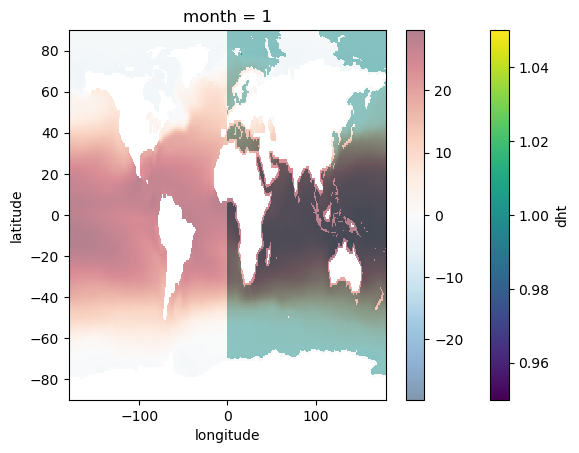

In [51]:
lsm[0].plot()
detrended_clim_coast[0].plot(alpha = 0.5)

In [147]:
def regrid_ACCESS(ds):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds['sst'].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [52]:
mask = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/sst_restore_mask_tropical_Pacific_Ocean_15S-15N_5degdampimg.nc", decode_times=False)

In [53]:
model_clim = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/global_sst_restoring_cm000_climatology_0951-1150.nc", decode_times=False)

In [54]:
grid_in = xe.util.grid_global(1, 1)

In [55]:
lonb = np.zeros_like(detrended_clim.longitude.values)
latb = np.zeros_like(detrended_clim.latitude.values)
lonb[:-1] = (detrended_clim.longitude.values[:-1] + detrended_clim.longitude.values[1:]) / 2
latb[:-1] = (detrended_clim.latitude.values[:-1] + detrended_clim.latitude.values[1:]) / 2

In [56]:
grid_in2 = {'lon': detrended_clim.longitude.values, 'lat': detrended_clim.latitude.values,
           'lon_b': lonb,
           'lat_b': latb}

In [57]:
grid_in1 = {'lon': detrended_clim.longitude.values, 'lat': detrended_clim.latitude.values}

In [58]:
lonb = np.zeros_like(model_clim.GRID_X_T.values)
latb = np.zeros_like(model_clim.GRID_Y_T.values)
lonb[:-1] = (model_clim.GRID_X_T.values[:-1] + model_clim.GRID_X_T.values[1:]) / 2
latb[:-1] = (model_clim.GRID_Y_T.values[:-1] + model_clim.GRID_Y_T.values[1:]) / 2

In [59]:
grid_out1 = {'lon': model_clim.GRID_X_T.values, 'lat': model_clim.GRID_Y_T.values}

In [60]:
grid_out = {'lon': model_clim.GRID_X_T.values, 'lat': model_clim.GRID_Y_T.values,
           'lon_b': lonb,
           'lat_b': latb}

In [61]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], model_clim.GRID_Y_T.values, {"units": "degrees_north"}),
        "lon": (["lon"], model_clim.GRID_X_T.values, {"units": "degrees_east"}),
    }
)
ds_out



<xarray.Dataset>
Dimensions:  (lat: 300, lon: 360)
Coordinates:
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * lon      (lon) float64 -279.5 -278.5 -277.5 -276.5 ... 76.5 77.5 78.5 79.5
Data variables:
    *empty*

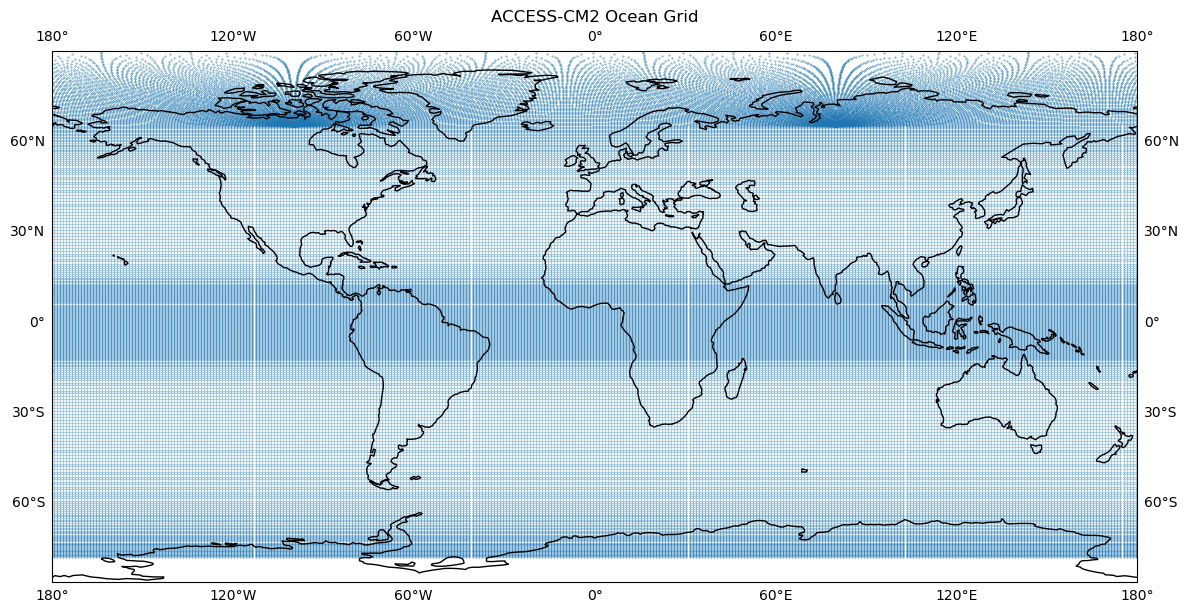

In [62]:
projection = ccrs.cartopy.crs.PlateCarree()
fig, axes = plt.subplots(ncols = 1, subplot_kw={'projection': projection}, figsize = (14, 8))

axes.scatter(ctrl_sst['geolon_t'], ctrl_sst['geolat_t'], s = 0.1, transform=ccrs.PlateCarree())  # plot grid locations
axes.set_title('ACCESS-CM2 Ocean Grid')
gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0, linestyle='--')
axes.coastlines()

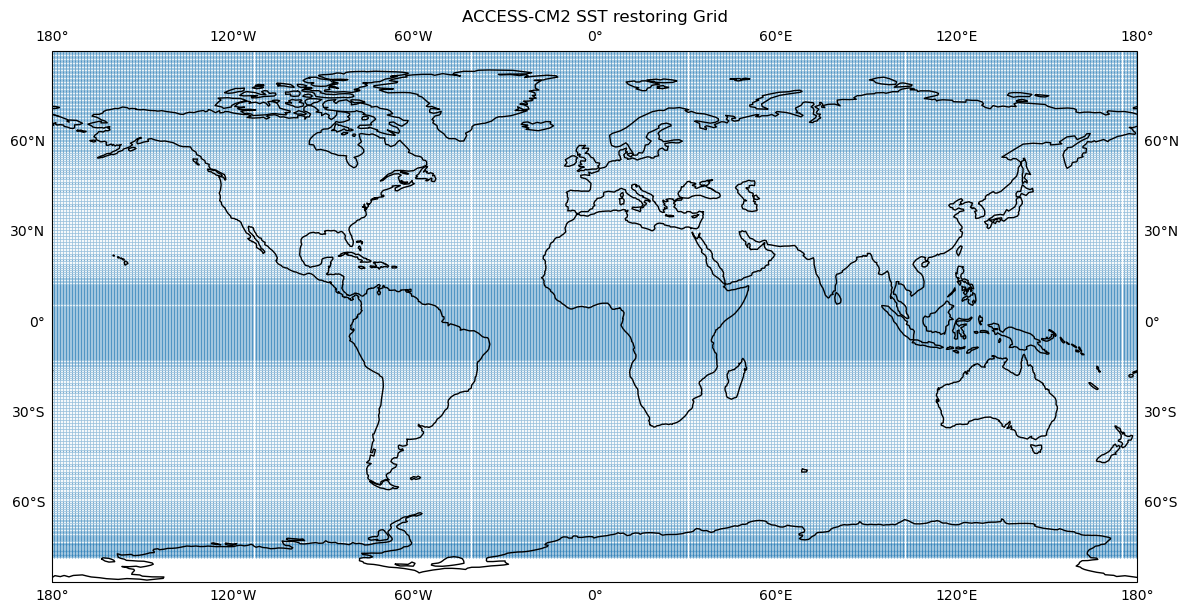

In [63]:
projection = ccrs.cartopy.crs.PlateCarree()
fig, axes = plt.subplots(ncols = 1, subplot_kw={'projection': projection}, figsize = (14, 8))

axes.scatter(np.tile(grid_out['lon'], 300).reshape(300,360), np.repeat(grid_out['lat'], 360).reshape(300,360), s = 0.1, transform=ccrs.PlateCarree())  # plot grid locations
axes.set_title('ACCESS-CM2 SST restoring Grid')
gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0, linestyle='--')
axes.coastlines()

ValueError: cannot reshape array of size 11664000 into shape (180,360)

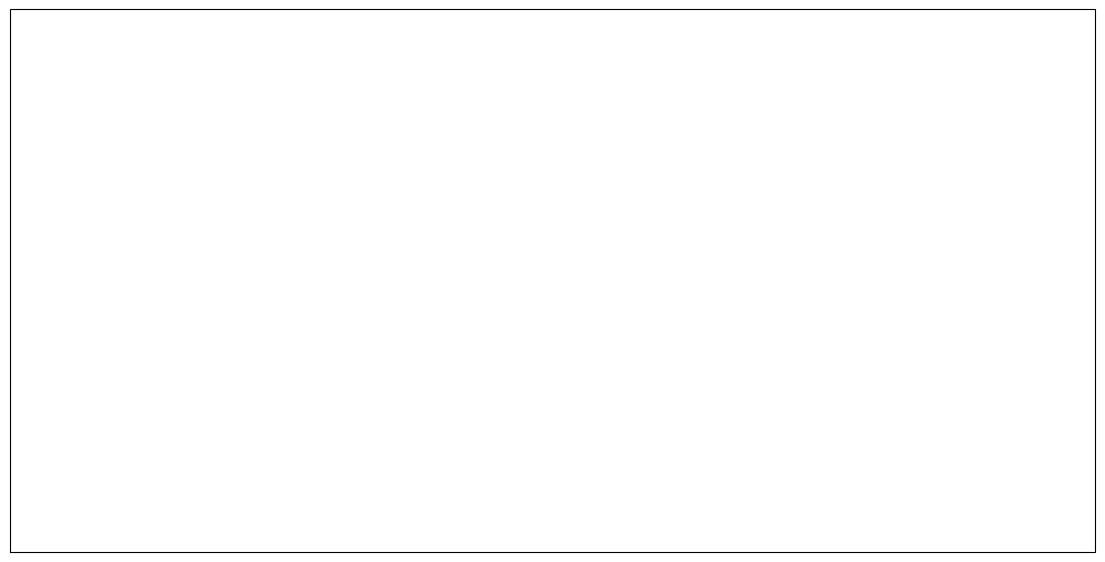

In [64]:
projection = ccrs.cartopy.crs.PlateCarree()
fig, axes = plt.subplots(ncols = 1, subplot_kw={'projection': projection}, figsize = (14, 8))

axes.scatter(np.tile(grid_in['lon'], 180).reshape(180,360), np.repeat(grid_in['lat'], 360).reshape(180,360), s = 0.1, transform=ccrs.PlateCarree())  # plot grid locations
axes.set_title('HadISST Grid')
gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=0.7, color='gray', alpha=0, linestyle='--')
axes.coastlines()

In [65]:
import cf_xarray

In [66]:
ds_out.cf

Coordinates:
- CF Axes:   X, Y, Z, T: n/a

- CF Coordinates: * longitude: ['lon']
                  * latitude: ['lat']
                    vertical, time: n/a

- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

Data Variables:
- Cell Measures:   area, volume: n/a

- Standard Names:   n/a

- Bounds:   n/a

In [67]:
RG = xe.Regridder(grid_in, ds_out, method = 'conservative', periodic=True)

In [68]:
RG

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_180x360_300x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (180, 360) 
Output grid shape:          (300, 360) 
Periodic in longitude?      False

In [69]:
test = RG(detrended_clim_coast)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('latitude', 'longitude') from data variable None as the horizontal dimensions for the regridding.
  warnings.warn(


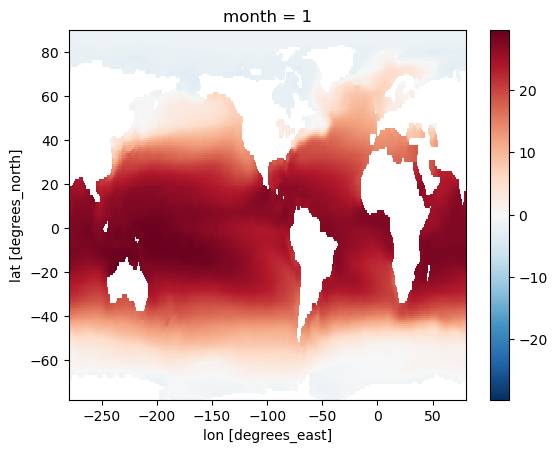

In [70]:
test[0].plot()

In [71]:
test1 = test.rename({"lon": "GRID_X_T", "lat": "GRID_Y_T", "month": "TIME"})

In [72]:
test2 = test1.expand_dims(dim =  {"DEPTH1_1":model_clim.DEPTH1_1})

In [73]:
test3 = test2.assign_coords({"GRID_X_T": model_clim.GRID_X_T, "GRID_Y_T": model_clim.GRID_Y_T, "TIME":model_clim.TIME, "DEPTH1_1":model_clim.DEPTH1_1})

In [74]:
test3 = test3.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})

In [75]:
test_4 = test3.to_dataset(name = 'temp')

In [76]:
test_4 = test_4.assign_attrs({"description": "Monthly HadISST climatology (Jan 1990- Dec 2019 inclusive). Detrended back to 1850 using the quadratic trend T2005-T1850. For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                             "history": "Created 21/04/23"})

In [77]:
test_4 = test_4[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]

In [81]:
#mask land values from source grid in the climatology

In [82]:
masked_regridded_Had_clim = test_4['temp'].where(np.isnan(model_clim['temp'][0,0]) == 0).to_dataset(name = 'temp')

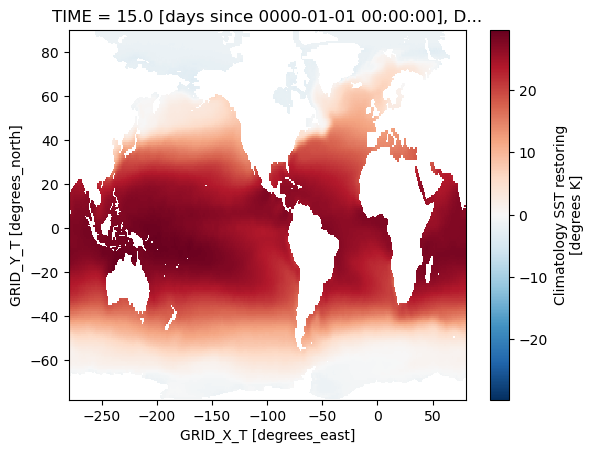

In [84]:
masked_regridded_Had_clim.temp[0,0].plot()

In [104]:
masked_regridded_Had_clim.to_netcdf("/g/data/e14/sm2435/Pacemaker/HadISST_Climatology.nc", encoding = {"TIME": {"_FillValue": None},
                                                                                    "DEPTH1_1": {"_FillValue": None},
                                                                                    "GRID_Y_T": {"_FillValue": None},
                                                                                    "GRID_X_T": {"_FillValue": None},
                                                                                    "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

In [85]:
model_clim['temp'].attrs

{'long_name': 'Climatology SST restoring',
 'units': 'degrees K',
 'valid_range': array([-10., 500.], dtype=float32)}

In [87]:
test_4

<xarray.Dataset>
Dimensions:   (TIME: 12, DEPTH1_1: 1, GRID_Y_T: 300, GRID_X_T: 360)
Coordinates:
  * TIME      (TIME) float64 15.0 44.0 73.5 104.0 ... 257.0 287.5 318.5 349.0
  * DEPTH1_1  (DEPTH1_1) float64 0.0
  * GRID_Y_T  (GRID_Y_T) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * GRID_X_T  (GRID_X_T) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
Data variables:
    temp      (DEPTH1_1, TIME, GRID_Y_T, GRID_X_T) float64 nan nan ... -1.8 -1.8
Attributes:
    description:  Monthly HadISST climatology (Jan 1990- Dec 2019 inclusive)....
    history:      Created 21/04/23

In [88]:
len(grid_out['lat'])

300

In [145]:
test.where(~np.isnan(test), -999)

<xarray.DataArray (lat: 300, lon: 360)>
array([[-999.        , -999.        , -999.        , ..., -999.        ,
        -999.        , -999.        ],
       [-999.        , -999.        , -999.        , ..., -999.        ,
        -999.        , -999.        ],
       [-999.        , -999.        , -999.        , ..., -999.        ,
        -999.        , -999.        ],
       ...,
       [  -1.80002033,   -1.80001994,   -1.80002031, ...,   -1.80014156,
          -1.80002046,   -1.80002061],
       [  -1.80004503,   -1.80004417,   -1.80004499, ...,   -1.80007852,
          -1.80004532,   -1.80004564],
       [  -1.80052411,   -1.80052364,   -1.80052409, ...,   -1.80052378,
          -1.80052428,   -1.80052445]])
Coordinates:
    month    int64 1
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * lon      (lon) float64 -279.5 -278.5 -277.5 -276.5 ... 76.5 77.5 78.5 79.5
Attributes:
    regrid_method:  bilinear

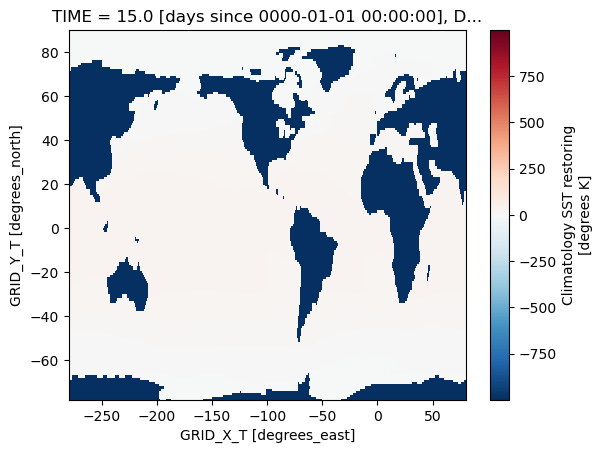

In [89]:
test_4['temp'].where(test_4['temp']>-100, -999, 0)[0,0].plot()

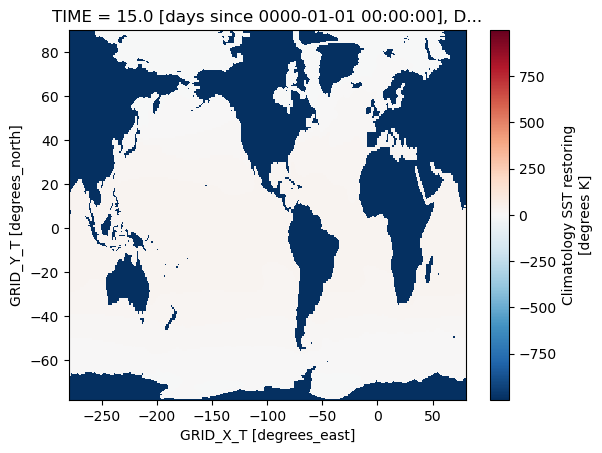

In [90]:
model_clim.temp.where(model_clim.temp>-100, -999, 0)[0,0].plot()

Text(0.5, 1.0, 'difference cons_normed regrid HadISST and ACCESS-CM2 restoring grid')

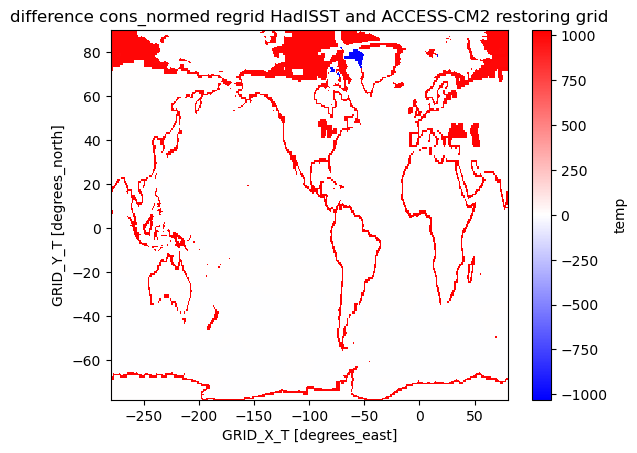

In [91]:
(test_4['temp'].where(test_4['temp']>-100, -1000, 0)[0,0] - model_clim.temp.where(model_clim.temp>-100, -1000, 0)[0,0]).plot(cmap = 'bwr')
plt.title("difference cons_normed regrid HadISST and ACCESS-CM2 restoring grid")

Text(0.5, 1.0, 'difference bilinear regrid HadISST and ACCESS-CM2 restoring grid')

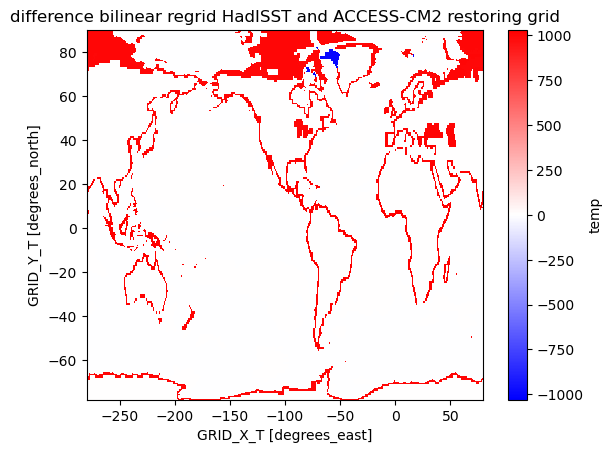

In [92]:
(test_4['temp'].where(test_4['temp']>-100, -1000, 0)[0,0] - model_clim.temp.where(model_clim.temp>-100, -1000, 0)[0,0]).plot(cmap = 'bwr')
plt.title("difference bilinear regrid HadISST and ACCESS-CM2 restoring grid")

Text(0.5, 1.0, 'difference conservative regrid HadISST and ACCESS-CM2 restoring grid')

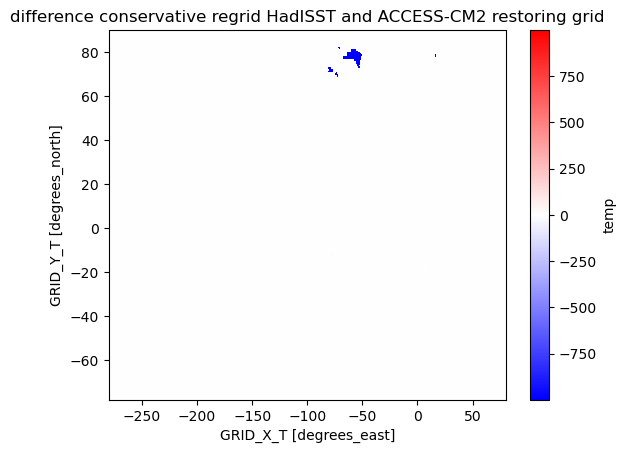

In [96]:
(masked_regridded_Had_clim['temp'].where(masked_regridded_Had_clim['temp']>-100, -1000, 0)[0,0] - model_clim.temp.where(model_clim.temp>-100, -1000, 0)[0,0]).plot(cmap = 'bwr')
plt.title("difference conservative regrid HadISST and ACCESS-CM2 restoring grid")


Text(0.5, 1.0, 'difference conservative regrid HadISST and ACCESS-CM2 restoring grid')

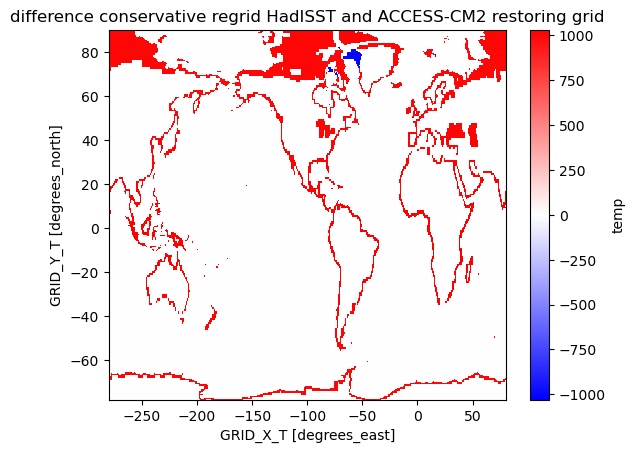

In [93]:
(test_4['temp'].where(test_4['temp']>-100, -1000, 0)[0,0] - model_clim.temp.where(model_clim.temp>-100, -1000, 0)[0,0]).plot(cmap = 'bwr')
plt.title("difference conservative regrid HadISST and ACCESS-CM2 restoring grid")

In [171]:
test2[0]

<xarray.DataArray (GRID_Y_T: 300, GRID_X_T: 360)>
array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
       [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]], dtype=float32)
Coordinates:
    DEPTH1_1  float64 0.0
    TIME      datetime64[ns] 1982-01-01
  * GRID_Y_T  (GRID_Y_T) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * GRID_X_T  (GRID_X_T) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
Attributes:
    regrid_method:  bilinear

In [166]:
(model_clim.temp.where(model_clim.temp>0, -999, 0)[0,0])

<xarray.DataArray 'temp' (GRID_Y_T: 300, GRID_X_T: 360)>
array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)
Coordinates:
    TIME      float64 15.0
    DEPTH1_1  float64 0.0
  * GRID_Y_T  (GRID_Y_T) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * GRID_X_T  (GRID_X_T) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
Attributes:
    long_name:    Climatology SST restoring
    units:        degrees K
    valid_range:  [-10. 500.]

Text(0.5, 1.0, 'Difference regridded OISSTV2 and ACCESS-CM2 Grids')

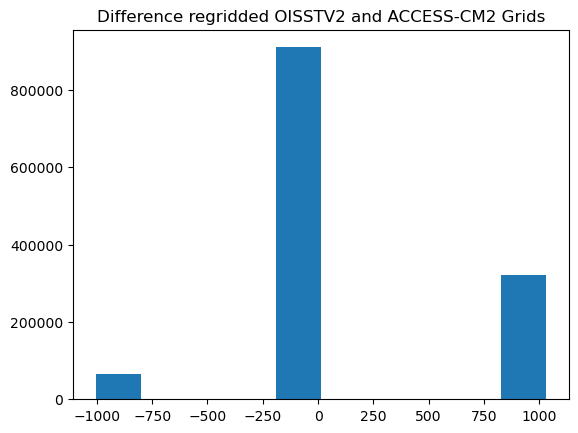

In [170]:
(test2.where(test2>0, -999, 0)[0] - model_clim.temp.where(model_clim.temp>0, -999, 0)[0,0]).plot()
plt.title("Difference regridded OISSTV2 and ACCESS-CM2 Grids")

Text(0.5, 1.0, 'Difference regridded HadISST and ACCESS-CM2 Grids')

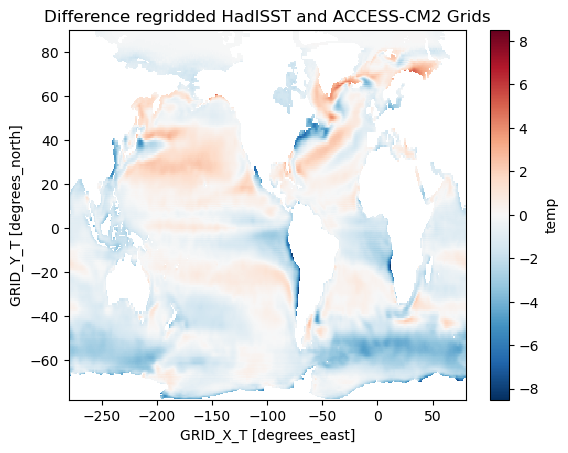

In [94]:
(masked_regridded_Had_clim.temp[0,0] - model_clim.temp[0,0]).plot()
plt.title("Difference regridded HadISST and ACCESS-CM2 Grids")

Text(0.5, 1.0, 'Difference regridded HadISST and ACCESS-CM2 Grids')

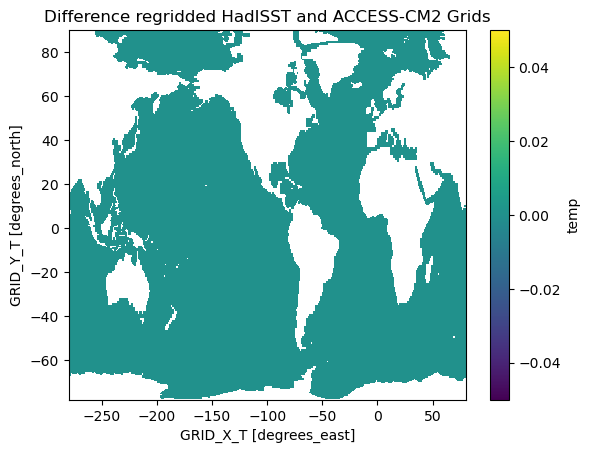

In [95]:
(masked_regridded_Had_clim.temp.where(np.isnan(masked_regridded_Had_clim.temp), -999)[0,0] - model_clim.temp.where(np.isnan(model_clim.temp), -999)[0,0]).plot()
plt.title("Difference regridded HadISST and ACCESS-CM2 Grids")

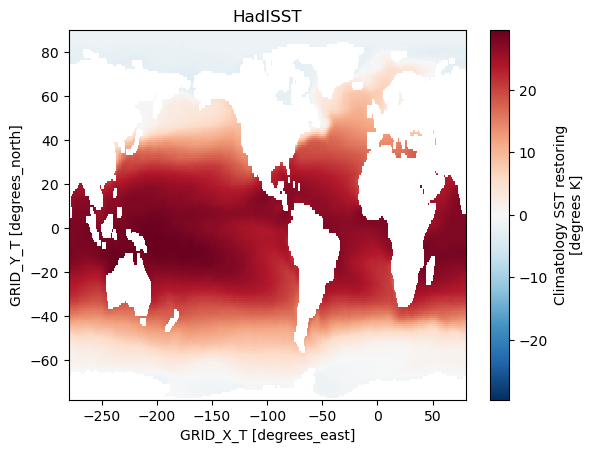

Text(0.5, 1.0, 'ACCESS-CM2')

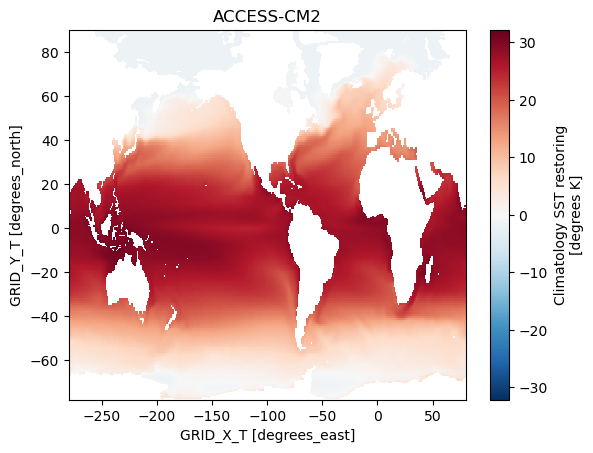

In [144]:
test_4.temp[0,0].plot()
plt.title("HadISST")
plt.show()
plt.figure()
model_clim.temp[0,0].plot()
plt.title("ACCESS-CM2")

In [147]:
oi = oiv2[0]

In [154]:
oi = oi.compute()

array([-140.   , -139.375, -138.75 , -138.125, -137.5  , -136.875,
       -136.25 , -135.625, -135.   , -134.375, -133.75 , -133.125,
       -132.5  , -131.875, -131.25 , -130.625, -130.   , -129.375,
       -128.75 , -128.125, -127.5  , -126.875, -126.25 , -125.625,
       -125.   , -124.375, -123.75 , -123.125, -122.5  , -121.875,
       -121.25 , -120.625, -120.   , -119.375, -118.75 , -118.125,
       -117.5  , -116.875, -116.25 , -115.625, -115.   , -114.375,
       -113.75 , -113.125, -112.5  , -111.875, -111.25 , -110.625,
       -110.   , -109.375, -108.75 , -108.125, -107.5  , -106.875,
       -106.25 , -105.625, -105.   , -104.375, -103.75 , -103.125,
       -102.5  , -101.875, -101.25 , -100.625, -100.   ,  -99.375,
        -98.75 ,  -98.125,  -97.5  ,  -96.875,  -96.25 ,  -95.625,
        -95.   ,  -94.375,  -93.75 ,  -93.125,  -92.5  ,  -91.875,
        -91.25 ,  -90.625,  -90.   ,  -89.375,  -88.75 ,  -88.125,
        -87.5  ,  -86.875,  -86.25 ,  -85.625,  -85.   ,  -84.

In [145]:
###Check if OISSTV2 can be detrended in the same way
#load observational SST
oiv2 = xr.open_dataset("/g/data/e14/sm2435/ACCESS_PIctrl/oisstv2.nc", chunks = {'time':12}).sst
#rename coords
oiv2 = oiv2.rename({"lon": "longitude", "lat": "latitude"})
oiv2 = oiv2.compute()
#load the lsm
lsm = xr.open_dataset("/g/data/e14/sm2435/ACCESS_PIctrl/oisstv2_lsm.nc").mask
#rename coords
lsm = lsm.rename({"lon": "longitude", "lat": "latitude"})
oiv2 = oiv2.where(lsm[0]==1)
oiv2 = oiv2.sel(time = slice("1982-01-01", "2019-12-31"))

In [93]:
anoms = (oiv2.groupby('time.month') - oiv2.groupby('time.month').mean('time')).drop('month')

In [94]:
da = anoms

In [95]:
da

<xarray.DataArray 'sst' (time: 456, latitude: 180, longitude: 360)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.        , -0.00026309, -0.00026309, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.00052631, -0.00026309, -0.00026309, ..., -0.00052631,
         -0.00052631, -0.00052631],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.00052631, -0.00052631, -0.00052631, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5

In [96]:
new_time = pd.date_range('1850-01-16', '1982-01-16', freq='M')

# create a new data array with zeros and the same dimensions as the original array
new_data = np.zeros((len(new_time)))
new_data[:] = np.nan #delete if i want to go back to zeros in middle

# create a new xarray DataArray with the new time index and the zero-filled data
new_array = xr.DataArray(new_data, coords=[new_time], dims=['time'])

# concatenate the new array with the original array along the time dimension
concatenated_array = xr.concat([new_array, da], dim='time')

In [97]:
# create a new time coordinate with monthly frequency for the years 1780-1800
new_times = pd.date_range(start='1680-01', end='1850-1', freq='M')
# create a new DataArray with the time coordinate and fill with NaNs
da_1680_1849 = xr.DataArray(data=np.nan, dims=('time', 'lat', 'lon'), coords={'time': new_times})

# select the slice of data from 1900 to 2020
da_1850_2020 = concatenated_array.sel(time=slice('1850-01-01', '2019-12-31'))

# reverse the order of the data along the time axis
da_1680_1849_data = da_1850_2020.isel(time=slice(None, None, -1))

# update the time coordinate to reflect the new time period
da_1680_1849_data['time'] = new_times

# reindex the data to add the new months from 1780-1800
da_1680_1849_data = da_1680_1849_data.reindex(time=da_1680_1849.time)

# concatenate the three slices along the time axis to get the final DataArray
da_symmetric = xr.concat([da_1680_1849_data, da_1850_2020], dim='time')

In [98]:
pv = da_symmetric.polyfit(dim = 'time', deg = 2)###THIS is the solution!

In [99]:
q = xr.polyval(da_symmetric.time, pv)

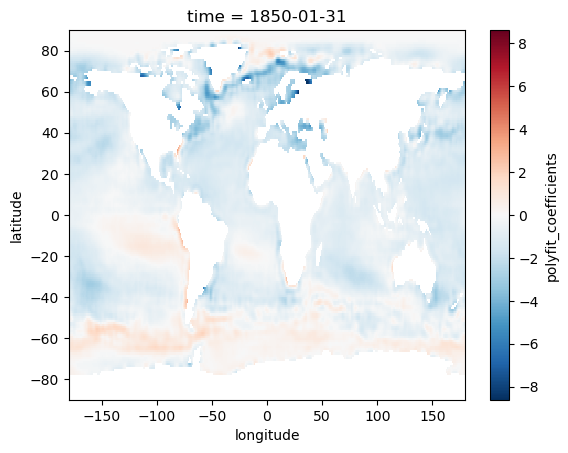

In [103]:
q.polyfit_coefficients[12*170].plot()

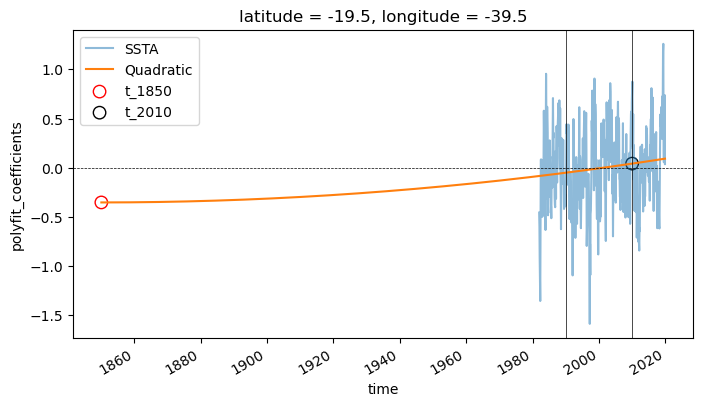

In [104]:
plt.figure(figsize = (8,4))
anoms.sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = 'SSTA', alpha = 0.5)
q.polyfit_coefficients.sel(time=slice("1850-01-01", "2019-12-31")).sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = 'Quadratic')
plt.scatter(q.polyfit_coefficients[12*170].sel(longitude=-40.0, latitude=-20.0, method='nearest').time, 
            q.polyfit_coefficients[12*170].sel(longitude=-40.0, latitude=-20.0, method='nearest').values, s=80, facecolors='none', edgecolors='r', label = 't_1850')
plt.scatter(q.polyfit_coefficients[-10*12].sel(longitude=-40.0, latitude=-20.0, method='nearest').time, 
            q.polyfit_coefficients[-10*12].sel(longitude=-40.0, latitude=-20.0, method='nearest').values, s=80, facecolors='none', edgecolors='k', label = 't_2010')

#q.polyfit_coefficients[12*170].sel(longitude=-40.0, latitude=-20.0, method='nearest').plot.scatter()
#q.polyfit_coefficients[-10*12].sel(longitude=-40.0, latitude=-20.0, method='nearest').plot.scatter()


#(anoms - q.polyfit_coefficients).sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = 'SSTA - trend', alpha = 0.7)

plt.axvline(datetime.strptime("1990-01-01", "%Y-%m-%d"), color = 'k', linestyle = '-', linewidth = 0.5)
plt.axvline(datetime.strptime("2009-12-31", "%Y-%m-%d"), color = 'k', linestyle = '-', linewidth = 0.5)
plt.axhline(0, color = 'k', linestyle = '--', linewidth = 0.5)

plt.legend()

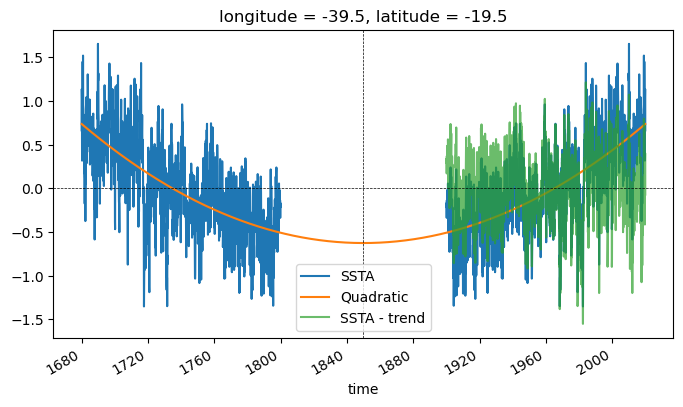

In [100]:
plt.figure(figsize = (8,4))
da_symmetric.sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = 'SSTA')
q.polyfit_coefficients.sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = 'Quadratic')

(anoms - q.polyfit_coefficients).sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = 'SSTA - trend', alpha = 0.7)

plt.axvline(datetime.strptime("1850-01-01", "%Y-%m-%d"), color = 'k', linestyle = '--', linewidth = 0.5)
plt.axhline(0, color = 'k', linestyle = '--', linewidth = 0.5)

plt.legend()


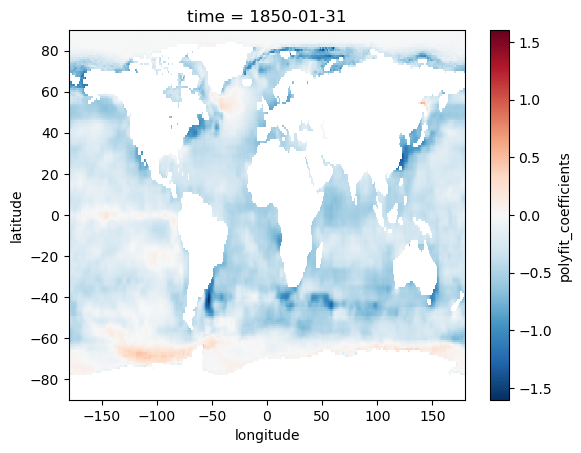

In [59]:
q.polyfit_coefficients[12*170].plot()

In [35]:
detrend_had = hadsst1 - q.polyfit_coefficients

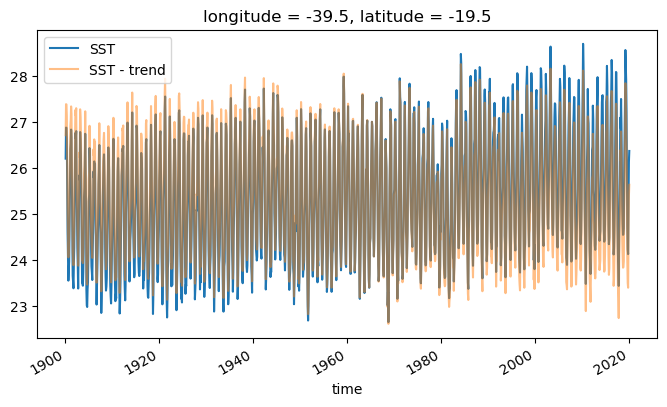

In [64]:
plt.figure(figsize = (8,4))
hadsst1.sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = "SST")
detrend_had.sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = "SST - trend", alpha = 0.5)

plt.legend()

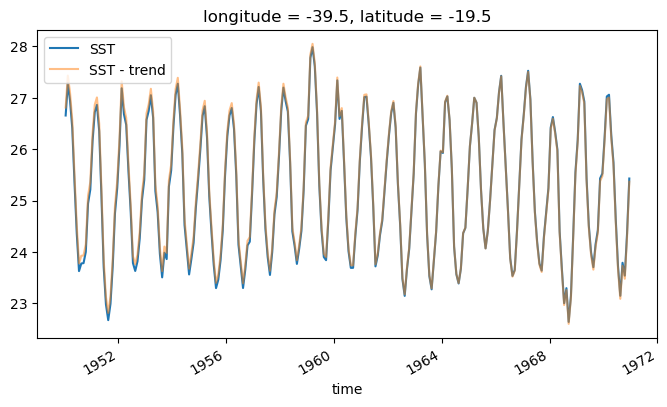

In [86]:
plt.figure(figsize = (8,4))
hadsst1.sel(longitude=-40.0, latitude=-20.0, method='nearest').sel(time = slice("1950-01-01", "1970-12-31")).plot(label = "SST")
detrend_had.sel(longitude=-40.0, latitude=-20.0, method='nearest').sel(time = slice("1950-01-01", "1970-12-31")).plot(label = "SST - trend", alpha = 0.5)

plt.legend()

In [66]:
detrend_clim = detrend_had.groupby('time.month').mean('time')

In [67]:
clim = hadsst1.groupby('time.month').mean('time')

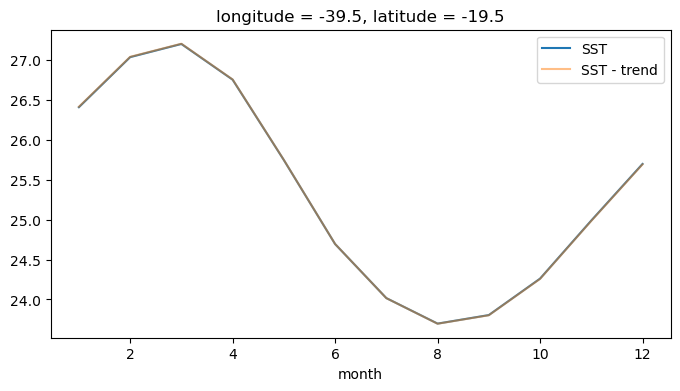

In [70]:
plt.figure(figsize = (8,4))
clim.sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = "SST")
detrend_clim.sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = "SST - trend", alpha = 0.5)

plt.legend()

In [91]:
(detrend_clim - clim).sel(longitude=-40.0, latitude=-20.0, method='nearest').min()

<xarray.DataArray ()>
array(-0.00477588)
Coordinates:
    longitude  float64 -39.5
    latitude   float64 -19.5

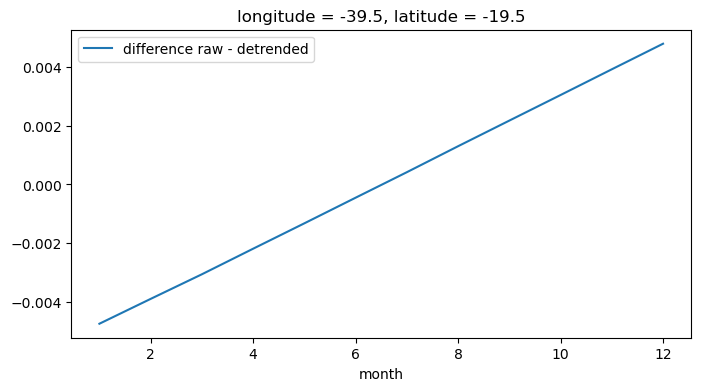

In [104]:
plt.figure(figsize = (8,4))
(clim - detrend_clim).sel(longitude=-40.0, latitude=-20.0, method='nearest').plot(label = "difference raw - detrended")
#plt.plot([1,12], [(detrend_clim - clim).sel(longitude=-40.0, latitude=-20.0, method='nearest').max(),
#                  (detrend_clim - clim).sel(longitude=-40.0, latitude=-20.0, method='nearest').min()])
plt.legend()

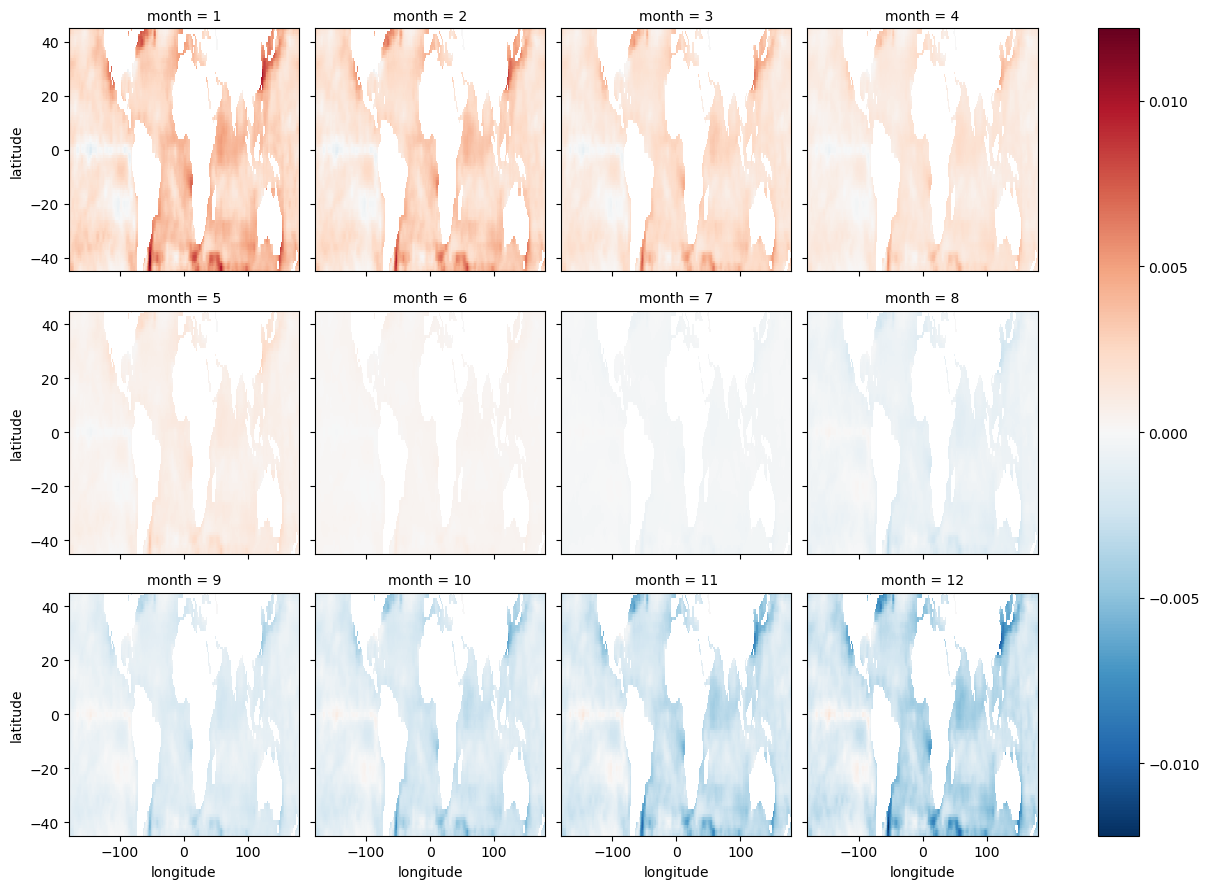

In [38]:
(detrend_clim - clim).sel(latitude=slice(-45,45)).plot(col='month', col_wrap = 4)

In [40]:
detrend_had

<xarray.DataArray (time: 1440, latitude: 180, longitude: 360)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
         -1.79999992,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1900-01-16T12:00:00 ... 2019-12-16T12:00:00
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5

In [23]:
1452/12

121.0